In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1) 載入資料集

In [27]:
df_train = pd.read_csv('./data/train.csv')
df_train = df_train.drop(labels=['Id'],axis=1) # 移除Id

## 2) 檢查缺失值
使用 numpy 所提供的函式來檢查是否有 NA 缺失值，假設有缺失值使用dropna()來移除。使用的時機在於當只有少量的缺失值適用，若遇到有大量缺失值的情況，或是本身的資料量就很少的情況下建議可以透過機器學習的方法補值來預測缺失值。

```python
# 移除缺失值
train=train.dropna()
```

In [28]:
# checked missing data
print("Before data clean(NAN mount):",len(np.where(np.isnan(df_train))[0]))

Before data clean(NAN mount): 0


## 3) 資料前處理

#### **特徵標準化**
通常有兩種標準化的方法：
- min max normalization：
    - 會將特徵數據按比例縮放到0到1的區間，（或是-1到1）。
- standard deviation normalization：
    - 會將所有特徵數據縮放成平均為0、平方差為1。
    
#### **特徵組合**
特徵需要適當地增加和減少，以提升精確度並減少計算時間。
- 增加特徵：特徵組合 (Feature Combination)、群聚編碼 (GroupBy Encoding)、產生合成樣本(Oversampling)
- 減少特徵：特徵篩選(Feature Selection)、剔除一些樣本(Undersampling)

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(df_input):
    # numeric feature standardization
    sc = StandardScaler()    
#     sc = MinMaxScaler()
    df=sc.fit_transform(df_input.iloc[:,0:54])
    return df

In [30]:
X = data_preprocessing(df_train)

In [31]:
X.shape

(14364, 54)

## 4) One hot encoding
對`Cover Type`輸出欄位的資料做 one-hot encoding，使用 Keras 提供的工具函式 to_categorical 將每筆資料的輸出值 y 轉換成一個向量。

In [32]:
y = df_train['Cover_Type'].values

In [1]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y-1)

NameError: name 'y' is not defined

## 4) 切割訓練集與測試集

In [34]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=.3 , random_state=42)

In [35]:
print('訓練資料: ',X_train.shape)
print('測試資料: ',X_test.shape)

訓練資料:  (10054, 54)
測試資料:  (4310, 54)


## 5) 建立網路模型

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

1.14.0


In [37]:
# 此範例使用 Tensorflow2.0 Sequential API 搭建神經網路。
def build_model():
    model = Sequential()
    model.add(Dense(256, Activation('relu'), input_dim=X.shape[-1]))
    model.add(Dense(128, Activation('relu')))
    model.add(Dense(64, Activation('relu')))
    model.add(Dense(32, Activation('relu')))
    model.add(Dense(16, Activation('relu')))
    model.add(Dense(8, Activation('relu')))
    model.add(Dense(7, Activation('softmax')))
    return model

In [38]:
model = build_model()
model.summary()   # Weights = (54+1)*256+(256+1)*128+(128+1)*64+(64+1)*32+(32+1)*16+(16+1)*8+(8+1)*7

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               14080     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 7)                

In [39]:
# 編譯模型
optim = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

batch_size=64
epochs = 50

# 訓練模型
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.1)


Train on 9048 samples, validate on 1006 samples
Epoch 1/50
9048/9048 [==============================] - 1s 82us/sample - loss: 1.3913 - acc: 0.4545 - val_loss: 1.0618 - val_acc: 0.5586
Epoch 2/50
9048/9048 [==============================] - 0s 44us/sample - loss: 0.9741 - acc: 0.5690 - val_loss: 0.8737 - val_acc: 0.6243
Epoch 3/50
9048/9048 [==============================] - 0s 43us/sample - loss: 0.8252 - acc: 0.6429 - val_loss: 0.7431 - val_acc: 0.6958
Epoch 4/50
9048/9048 [==============================] - 0s 44us/sample - loss: 0.7134 - acc: 0.6992 - val_loss: 0.6587 - val_acc: 0.7266
Epoch 5/50
9048/9048 [==============================] - 0s 47us/sample - loss: 0.6621 - acc: 0.7215 - val_loss: 0.6575 - val_acc: 0.7406
Epoch 6/50
9048/9048 [==============================] - 0s 44us/sample - loss: 0.6230 - acc: 0.7409 - val_loss: 0.6029 - val_acc: 0.7584
Epoch 7/50
9048/9048 [==============================] - 0s 45us/sample - loss: 0.5856 - acc: 0.7539 - val_loss: 0.5977 - val_acc: 

## 6) 觀察訓練結果

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_ = range(1,len(acc)+1)

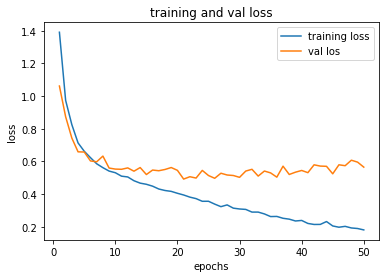

In [42]:
plt.plot(epochs_ , loss , label = 'training loss')
plt.plot(epochs_ , val_loss , label = 'val los')
plt.title('training and val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

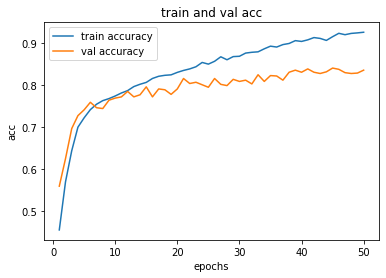

In [43]:
plt.clf()
plt.plot(epochs_ , acc , label='train accuracy')
plt.plot(epochs_ , val_acc , label = 'val accuracy')
plt.title('train and val acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

## 測試集預測

In [44]:
from sklearn.metrics import accuracy_score
label=np.argmax(y_test,axis=1)
pred =  np.argmax(model.predict(X_test), axis=1)
accuracy_score(label, pred)

0.814385150812065

## 預測 test.csv

In [45]:
df_test = pd.read_csv('./data/test.csv')
df_test = df_test.drop(labels=['Id'],axis=1)
test =data_preprocessing(df_test)

pred =  np.argmax(model.predict(test), axis=1)
predict_class = pred+1

In [46]:
submission=pd.read_csv('./data/sampleSubmission.csv')
df_test = pd.read_csv('./data/test.csv')
ans=pd.DataFrame(np.empty([len(df_test),2]), columns=['Id','class'], dtype='int32')

In [47]:
ans['Id']=df_test['Id']
ans['class']=predict_class
ans.to_csv('./submission.csv',header=['Id','class'],index=False)